<a href="https://colab.research.google.com/github/VidushiBhatia/Customer-Segmentation/blob/main/Customer%20Segmentation%20-%20Data%20Prep%20%26%20EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation on [Instacart](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2) Data

**Part 1 - Data Pre-Processing, EDA & Feature Engineering**



## 1. Install Relevant Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 2. Read Files and Understand Data

   * Read all the files
   * Review Tables to get a sense of the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
############################################ Helper Function 1 ############################################################
############################################### READ FILES ################################################################

def read_data(path):
  all_dfs = {}
  df = pd.DataFrame()
  files = os.listdir(path) 
  missing_value_formats = ["n.a.","?","NA","n/a", "na", "--","-"]
  
  for file in files:
    if file.endswith('.csv'):
      all_dfs[file[:file.find(".")]] = pd.read_csv(os.path.join(path,file), na_values = missing_value_formats)
  return all_dfs

############################################ Helper Function 2 ############################################################
############################################ SUMMARIZE FILES ##############################################################

def summarize_data(df):
  print("\nOverview")
  display(df.head())
  print("\nSummary")
  display(df.describe(include='all'))
  print("\nNull Values")
  display(df.isnull().sum()/len(df))

In [ ]:
# Understand the available data

path = '/content/drive/MyDrive/instacart-market-basket-analysis/'
all_dfs = read_data(path)

print("\n############################## AISLES ##############################")
summarize_data(all_dfs['aisles'])
print("\n############################## DEPARTMENTS ##############################")
summarize_data(all_dfs['departments'])
print("\n############################## ORDER-PRODUCTS PRIOR ##############################")
summarize_data(all_dfs['order_products__prior'])
print("\n############################## ORDER-PRODUCTS TRAIN ##############################")
summarize_data(all_dfs['order_products__train'])
print("\n############################## ORDERS ##############################")
summarize_data(all_dfs['orders'])
print("\n############################## PRODUCTS ##############################")
summarize_data(all_dfs['products'])
print("\n############################## SAMPLE SUBMISSION ##############################")
summarize_data(all_dfs['sample_submission'])


In [ ]:
# MISSING VALUE TREATMENT

# Checking reason for Missing values and applying app missing value treatment

all_dfs['orders'].loc[all_dfs['orders']['order_number']==1, 'days_since_prior_order'] = 0
summarize_data(all_dfs['orders'])

<br>

**Overview of Tables**

| Table Name | Column Names | Description | Hypothesis for Data Exploration  |
| --- | --- | --- | --- | 
| aisles | aisle_id, aisle | 134 unique IDs, names for different aisles at Instacart | aisle which generates highest revenue, most frequently used aisle, distribution of<br> aisle usage based on demographics and other customer info, is there a trend of<br> aisle popularity with time of day, day of week, or any specific month of year? |
| departments | department_id, department | 21 unique IDs, names for different departments including 'missing'<br> - looks like the rolled-up metric for aisles e.g. one department might <br> have multiple aisles | revenue by dept, frequency of use by dept, distribution of dept usage based<br> on demographics and other available customer info, dept popularity by time <br>of day, day of week, or any specific month of year  |
| order-products-prior | order_id, product_id, add_to_cart_order, reordered | 32,434,489 rows at order-product level with 3,214,874 unique orders <br>for 49,677 unique products. 'add_to_cart_order' shows the order in which<br> they were added to the cart and 'reordered' | most ordered products, most frequent re-ordered products, products which <br>are only ordered once and not reordered, Number of products in one order,<br> are the products that are ordered together from the same aisle/dept? |
 | order-products-train | order_id, product_id, add_to_cart_order, reordered | Similar to df_prior_orders but only has latest order information. 1,384,617 rows<br> with 131,209 unique order IDs and 39,123  | most ordered products, most frequent re-ordered products, products <br>which are only ordered once and not reordered, Number of products in <br>one order, are the products that are ordered together from the same aisle/dept? |
| orders | order_id, user_id, eval_set,<br> order_number, order_dow,<br> order_hour_of_day, days_since_prior_order | 3,421,083 orders showing information on order ID, user ID, which evaluation<br> dataset the order is in (prior, train, test), day of week, hour of day,<br> days since prior order | Most popular day & time for placing an order, trend of day & time by products |
| products | product_id, product_name, aisle_id, department_id | 49,688 rows mapping products to aisles and departments |	covered in above metrics |

<br>

**Missing Values**

* 6% values are missing for 'days since prior order' in 'orders' df --> Given these are only for Order Number 1, we can replace missing values with '0' days
* No other missing values found in the data
* FYI - We can use Imputers from sklearn in couldn't replace our missing data with 0



## 3. Create a Master Dataset

In [ ]:
# Prior and Train order datasets have the same columns orders from different time frame - These need to be concatenated

master_df = pd.concat([all_dfs['order_products__prior'], all_dfs['order_products__train']]).sort_values(by=['order_id'])

# Merge the rest of the datasets
master_df = pd.merge(left = master_df, right = all_dfs['products'],
                             left_on='product_id', right_on='product_id').sort_values(by=['order_id']).reset_index(drop=True)
master_df = pd.merge(left = master_df, right = all_dfs['aisles'],
                             left_on='aisle_id', right_on='aisle_id').sort_values(by=['order_id']).reset_index(drop=True)
master_df = pd.merge(left = master_df, right = all_dfs['departments'],
                             left_on='department_id', right_on='department_id').sort_values(by=['order_id']).reset_index(drop=True)
master_df = pd.merge(left = master_df, right = all_dfs['orders'],
                             left_on='order_id', right_on='order_id').sort_values(by=['order_id']).reset_index(drop=True)

col_order = ['user_id','order_id','product_id','aisle_id','department_id','add_to_cart_order',
 'reordered','product_name','aisle','department','eval_set','order_number','order_dow','order_hour_of_day',
 'days_since_prior_order']

master_df = master_df[col_order]

summarize_data(master_df)

## 4. EDA

* which Q is each chart answering?
* what is the answer? insight?
* identify highly correlated variables
* identify variables with (nearly) no variance

In [ ]:
############################################ Helper Function 3 ############################################################
############################################ VISUALIZE DATA ##############################################################

def CreateCharts (ax, data, x, y, chart_type, legend = False, size = 5, hue = None, palette=None):
    if chart_type == "scatter":
        plot = sns.scatterplot(data=data, x=x, y=y, size=size, legend=legend, 
                hue=hue, sizes=(20, 200), palette = palette, ax=ax)
    elif chart_type == "bar":
        plot = sns.barplot(x=x, y=y, data=data, 
                hue=hue, palette = palette, ax=ax)
    elif chart_type == "density":
        plot = sns.kdeplot(x=x, data=data, 
                shade=True, alpha=0.5, ax=ax)  
    elif chart_type == "swarm":
        plot = sns.swarmplot(x=x, y=y, hue=hue, data=data,
                      palette=palette, ax=ax)
    return plot

In [ ]:
sns.pairplot(master_df)

In [ ]:
# Start with general univariate analysis

fig, ax = plt.subplots(3,2, figsize=(20,40))

# CreateCharts(ax[0,0], data, x, y, chart_type, legend = False, size = 5, hue = 'reorders'', palette=None)
sns.swarmplot(hue=hue, data=data,
                      palette=palette, ax=ax)

ValueError: ignored

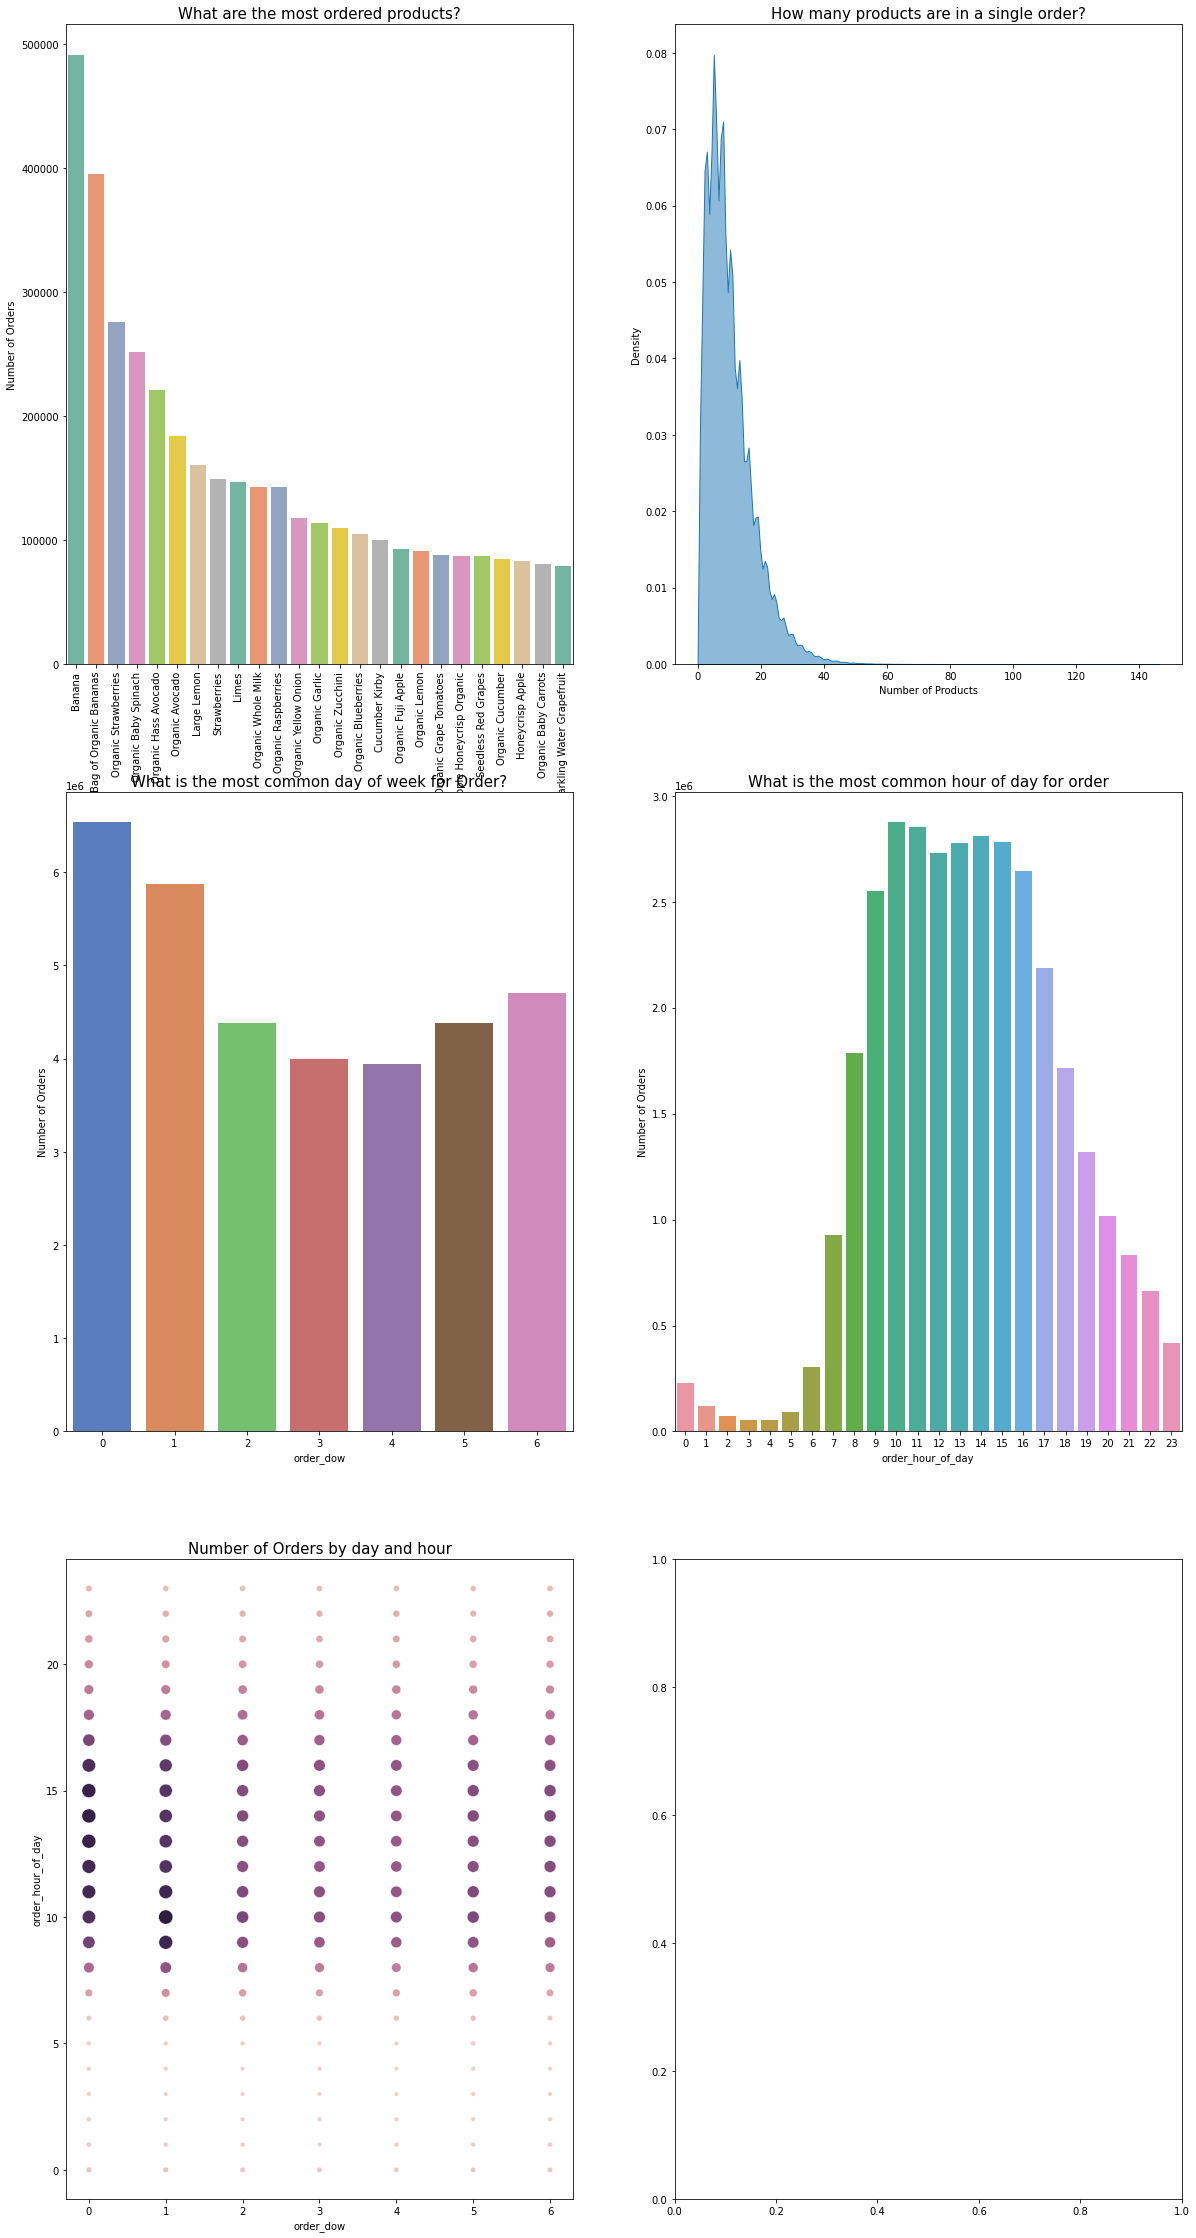

In [51]:
# 1. orders
# > Most ordered products
# > Number of products in one order
# > Trend of Orders by day and time

fig, ax = plt.subplots(3,2, figsize=(20,40))

# Plot 1
data = master_df.groupby(['product_id','product_name']).size().reset_index(name='Number of Orders').sort_values(by='Number of Orders', ascending=False)
data = data.head(25)

ax[0,0] = CreateCharts(ax[0,0], data, "product_name", "Number of Orders", "bar", palette = "Set2")
ax[0,0].set_xticklabels(data['product_name'], rotation = 90)
ax[0,0].set_title('What are the most ordered products?', fontsize=15)
ax[0,0].set_xlabel('')

# Plot 2
data = master_df.groupby('order_id').size().reset_index(name='Number of Products').sort_values(by='Number of Products', ascending=False)
ax[0,1] = CreateCharts(ax[0,1], data, x = "Number of Products", y=None, chart_type = "density")
ax[0,1].set_title('How many products are in a single order?', fontsize=15)


# Plot 3
ax[1,0] = CreateCharts(ax[1,0], 
            master_df.groupby('order_dow').size().reset_index(name='Number of Orders'),
            "order_dow", "Number of Orders", "bar", palette = 'muted')
ax[1,0].set_title('What is the most common day of week for Order?', fontsize=15)

# Plot 4
ax[1,1] = CreateCharts(ax[1,1], 
            master_df.groupby('order_hour_of_day').size().reset_index(name='Number of Orders'),
            "order_hour_of_day", "Number of Orders", "bar", palette = None)
ax[1,1].set_title('What is the most common hour of day for order', fontsize=15)


# Plot 5
# ax[2,0] = CreateCharts(ax[2,0],
#     all_dfs['orders'][all_dfs['orders']['eval_set']!='test'].groupby(['order_dow', 'order_hour_of_day']).size().reset_index(name='orders'),
#     "order_dow", "order_hour_of_day", "scatter", legend=False, size="orders", hue = "orders")
# ax[2,0].set_title('Number of Orders by day and hour', fontsize=15)

# Plot 6
data = master_df.groupby('product_name')['reordered'].sum().sort_values(ascending=False)
ax[2,1] = CreateCharts(ax[2,1], data.head(25), , "reordered", "bar", palette = "Set2")
ax[2,1].set_xticklabels(data.head(25)['product_name'], rotation = 90)
ax[2,1].set_title('What are the most reordered products?', fontsize=15)
ax[2,1].set_xlabel('')

#  2. reorders
# > How many current orders (train set) are also previously ordered (prior orders)
# > products which are most likely to be reordered, is there any trend in reorders vs orders
# > Number of orders and period of reorders

# 3. aisles
# > Number of products in each aisle
# > Number of orders in each aisle (combine this with above?)
# > dow and hour of day for aisle
# > reorder period for each aisle, most reorders by each aisle
# > are the products from the same aisle ordered together

# 4. departments
# > Number of products in each dept
# > Number of orders in each dept (combine this with above?)
# > dow and hour of day for dept
# > reorder period for each dept, most reorders by each dept
# > are the products from the same dept ordered together

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=1)

plt.show()

In [ ]:
# Variance Check

from sklearn.feature_selection import VarianceThreshold
threshold = 0.8 # 80% of low variance
fe_low_variance = VarianceThreshold(threshold=(threshold * (1 - threshold)))
X_variance = fe_low_variance.fit_transform(X)

In [ ]:
# Correlation

plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', size = 15)
colormap = sns.diverging_palette(10, 220, as_cmap = True)
sns.heatmap(corr_df.corr(),
            cmap = colormap,
            square = True,
            annot = True,
            linewidths=0.1,vmax=1.0, linecolor='white',
            annot_kws={'fontsize':12 })
plt.show()

## 5. Feature Engineering

add any new variables you'd like to use -- like the ones above or RFM or use PCA to create new features

* User Features
* Product Features
* Time Features
* User-Product Features
* RFM
* remove/transform some variables (maybe your model does not like categorial variables)
* Normalize variables for k-means

In [ ]:
from sklearn.decomposition import PCA
N_var = 2
pca = PCA(n_components=N_var)
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2'])

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
N_var = 2
lda = LinearDiscriminantAnalysis(n_components=N_var)
# run an LDA and use it to transform the features
X_lda = lda.fit(X, y).transform(X)

## Next Blog

### Unsupervised - Clustering
* Unsupervised - Feature Selection Use this link for feature importance -- https://towardsdatascience.com/a-starter-pack-to-exploratory-data-analysis-with-python-pandas-seaborn-and-scikit-learn-a77889485baf#3534
* Unsupervised - Model Selection, Cost Function, Optimization, Accuracy Metric 
* Unsupervised - Modelling
* Unsupervised - Predict
* Unsupervised - Narrative for each segment

### Convert into Supervised for Prediction
* Use GridSearchCV and RandomForest, XGBoost